Initial setup and first topic model run

In [79]:
%reload_ext autoreload
%autoreload 2

In [80]:
import wosis
import pandas as pd
import metaknowledge as mk

In [81]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [82]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [83]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)
#maybe we don't want to do this for this analysis? older papers less likely to have dois?

Removing 1799 records with no DOIs


In [84]:
# removed_pubs

In [85]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2011,Lumped parameter sensitivity analysis of a dis...,"Cuo, Lan|Giambelluca, Thomas W.|Ziegler, Alan D.",HYDROLOGICAL PROCESSES
1,2008,SWAT model application in a data scarce tropic...,"Ndomba, Preksedis|Mtalo, Felix|Killingtveit, A...",PHYSICS AND CHEMISTRY OF THE EARTH
2,2008,Extension and evaluation of sensitivity analys...,"Napelenok, S. L.|Cohan, D. S.|Odman, M. T.|Ton...",ENVIRONMENTAL MODELLING & SOFTWARE
3,2015,Geological realism in hydrogeological and geop...,"Linde, Niklas|Renard, Philippe|Mukerji, Tapan|...",ADVANCES IN WATER RESOURCES
4,2012,Optimal Allocation of Resources for the Maximi...,"Singh, Ajay",JOURNAL OF IRRIGATION AND DRAINAGE ENGINEERING


In [86]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

In [87]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [88]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(4),
    # 'UA': topic_results.get_topic_by_id(8),
    # 'SA': topic_results.get_topic_by_id(20),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3203

In [89]:
# find paper of interest - see if it's still in the corpora
for i in range(1,6):
    topic_set = topic_results.get_topic_by_id(i)
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = wosis.rc_to_df(topic_recs)
    
    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [90]:
topic_4_set = topic_results.get_topic_by_id(4)

In [91]:
topic_4_set.loc[:, ~topic_4_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
3,2015,Geological realism in hydrogeological and geop...,"Linde, Niklas|Renard, Philippe|Mukerji, Tapan|...",ADVANCES IN WATER RESOURCES
5,2008,Global sensitivity analysis for a numerical mo...,"Volkova, E.|Iooss, B.|Van Dorpe, F.",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...
8,2017,Multi-scale equation of state computations for...,"Thomas, Edward|Lucia, Angelo",COMPUTERS & CHEMICAL ENGINEERING
9,2015,Using uncertainty of Penman and Penman-Monteit...,"Westerhoff, R. S.",REMOTE SENSING OF ENVIRONMENT
11,2016,Computational uncertainty quantification for a...,"Barth, Andrea|Burger, Raimund|Kroeker, Ilja|Ro...",COMPUTERS & CHEMICAL ENGINEERING
17,2009,ADC Based Measurements: Identification of the ...,"Spataro, Ciro",2009 IEEE INTERNATIONAL WORKSHOP ON ADVANCED M...
18,2012,Stochastic Model for Damage Accumulation in Ru...,"Castillo, Carmen|Castillo, Enrique|Fernandez-C...",JOURNAL OF WATERWAY PORT COASTAL AND OCEAN ENG...
24,2017,Assessing the importance of demographic parame...,"Eacker, Daniel R.|Lukacs, Paul M.|Proffitt, Ke...",ECOLOGICAL APPLICATIONS
25,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT
32,2007,On the treatment of uncertainties in structura...,"Schueller, G. I.",COMPUTERS & STRUCTURES


In [92]:
topic_4_recs = wosis.extract_recs(topic_4_set.loc[:, 'id'], RC, 'Topic of Interest')

In [93]:
#run topic model on topic 4
topic_4_subtopics = find_topics(topic_4_set, num_topics=5)

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Topic 1: uncertainty model uncertainties analysis water data quality models assessment modeling
Topic 2: stochastic polynomial chaos random quantification equations method expansion collocation solution
Topic 3: sensitivity analysis model models global parameters indices input based output
Topic 4: bayesian model data parameter models calibration inference posterior prior estimation
Topic 5: carlo monte sampling method probability simulation failure distribution reliability function


<hr>

Plotting subtopic trends over time. <br>
Two topics are chosen, papers focusing on applications of SA and papers focusing on theoretical development of SA. <br>
The next task is to superimpose the category trends over time. <br>
Journal publication trends and top cited papers to indicate which fields are applying or interested in the theory of UA/SA. <br>
Author citation networks to indicate which fields are collaborating.

In [94]:
subtopic1 = topic_4_subtopics.get_topic_by_id(1)
subtopic3 = topic_4_subtopics.get_topic_by_id(3)
subtopic4 = topic_4_subtopics.get_topic_by_id(4)

In [95]:
uncertainty_model__applications = wosis.extract_recs(subtopic1['id'], RC, name='applications')

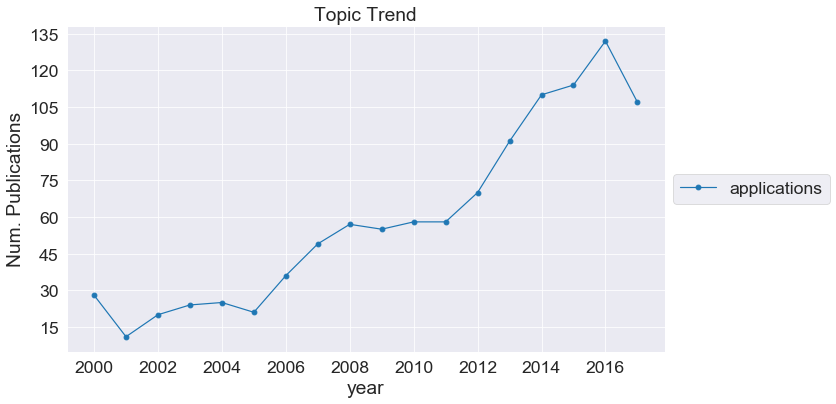

In [96]:
wos_plot.plot_topic_trend([uncertainty_model__applications, ], total_rc=None, title='Topic Trend')

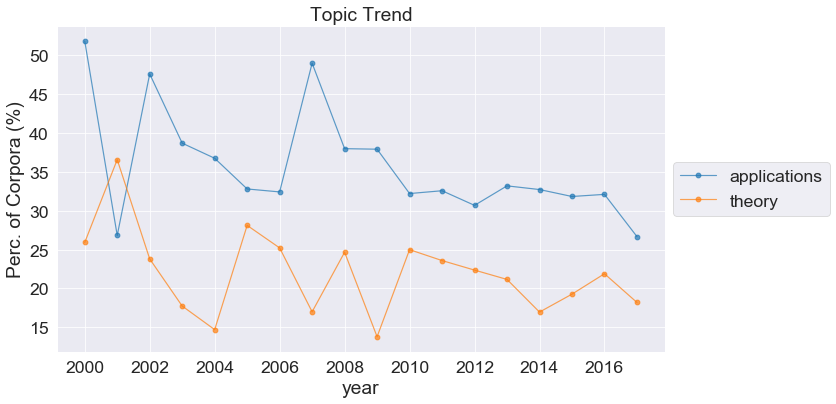

In [97]:
uncertainty_model__sa = wosis.extract_recs(subtopic3['id'], RC, name='theory')

wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=topic_recs, title='Topic Trend')

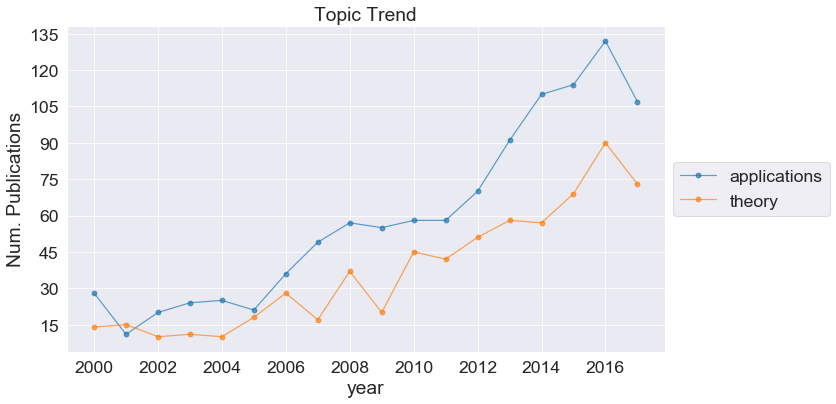

In [98]:
wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=None, title='Topic Trend')

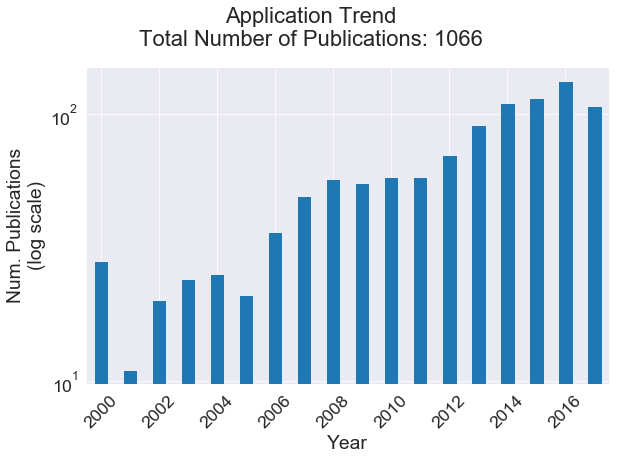

In [99]:
wos_plot.plot_pub_trend(uncertainty_model__applications, title='Application Trend', save_plot_fn='apptrend_2000-2016.png')

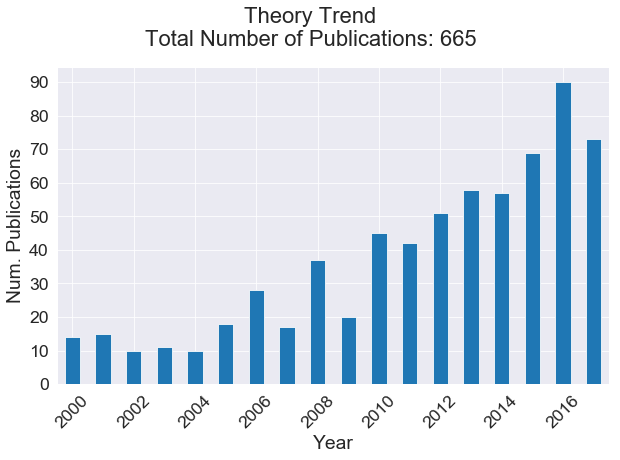

In [100]:
wos_plot.plot_pub_trend(uncertainty_model__sa, title='Theory Trend', save_plot_fn='theotrend_2000-2016.png')

In [101]:
#topic 2 of interest
uncertainty_model__applications_df = wosis.rec_to_df(uncertainty_model__applications)
topic_results = find_topics(uncertainty_model__applications_df, num_topics=5)

Topic 1: model analysis models data uncertainties parameters modeling using method results
Topic 2: glue parameter model calibration hydrological likelihood swat watershed estimation generalized
Topic 3: flood inundation damage forecasting mapping maps forecasts historical rainfall probabilistic
Topic 4: quality urban modelling drainage water stormwater pollutant integrated sewer data
Topic 5: dose doses internal deposition distributions public uncertainties values individual exposure


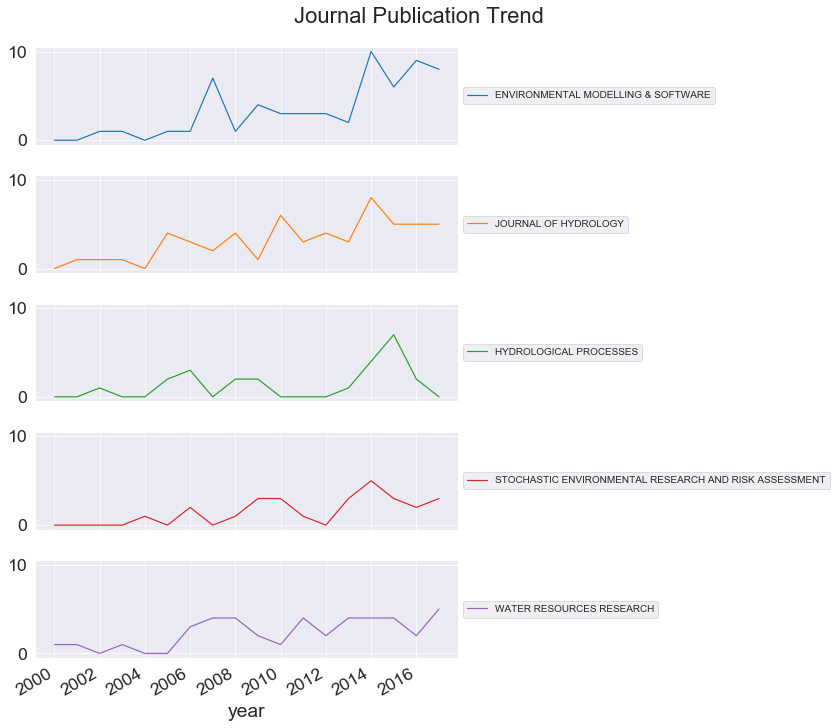

In [102]:
wos_plot.plot_journal_pub_trend((uncertainty_model__applications), top_n=5, save_plot_fn='journal_app_trend.png')

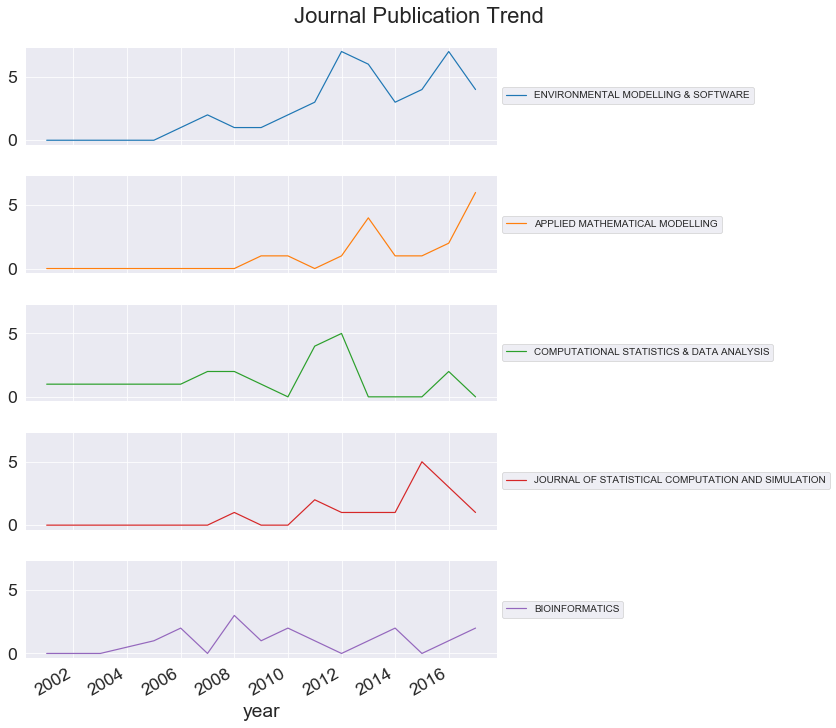

In [103]:
wos_plot.plot_journal_pub_trend((uncertainty_model__sa), top_n=5, save_plot_fn='journal_theo_trend.png')

In [120]:
journals_of_interest = ['Journal of Computational Physics'.upper(), 'Computer Methods in Applied Mechanics and Engineering'.upper(),
                       'Water Resources Research'.upper(), 'Environmental Modelling & Software'.upper(), 'Journal of Hydrology'.upper()]
pubs_for_journals_apps = wosis.find_pubs_by_journal(uncertainty_model__applications, journals_of_interest)

In [121]:
import glob

data_dir = "tmp"  # Using the temporary data directory
wos_config = wosis.load_config("config.yml")

# Get citations for each paper
paper_citations_per_journal_apps = {}
for pubs in pubs_for_journals_apps:
    fn = '{}/{}_citations_apps.csv'.format(data_dir, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal_apps[pubs] = wosis.get_num_citations(pubs_for_journals_apps[pubs], wos_config)
        paper_citations_per_journal_apps[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal_apps[pubs] = pd.read_csv(fn)

Authenticated (SID: 7D3yDHVA45ZsaWjuYBs)


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:32<00:00,  1.77it/s]


Authenticated (SID: 6EiHPqpEC8GxUiaRoBj)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.93it/s]


Authenticated (SID: 6DsllmZOxAyBXD8iwUE)


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:23<00:00,  1.81it/s]


Authenticated (SID: 7ESIqtiHrnn88l1Wext)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.84it/s]


Authenticated (SID: 7BZ4eJjfFLRZC4y8wD7)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


In [122]:
journal_apps = paper_citations_per_journal_apps['JOURNAL OF HYDROLOGY']

journal_apps = journal_apps.set_index(journal_apps.title)

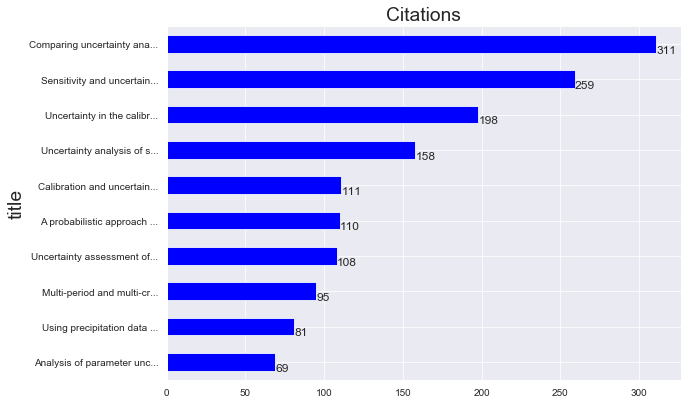

In [123]:
wos_plot.plot_citations(journal_apps)

In [124]:
journal_apps[['AU', 'year', 'DOI']][0:5]

,AU,year,DOI
title,,,
Comparing uncertainty ana...,"Yang, Jing|Reichert, Peter|Abbaspour, K. C.|Xi...",2008,10.1016/j.jhydrol.2008.05.012
Sensitivity and uncertain...,"Muleta, MK|Nicklow, JW",2005,10.1016/j.jhydrol.2004.09.005
Uncertainty in the calibr...,"Pappenberger, F|Beven, K|Horritt, M|Blazkova, S",2005,10.1016/j.jhydrol.2004.06.036
Uncertainty analysis of s...,"Khan, MS|Coulibaly, P|Dibike, Y",2006,10.1016/j.jhydrol.2005.06.035
Calibration and uncertain...,"Zhang, Xuesong|Srinivasan, Raghavan|Bosch, David",2009,10.1016/j.jhydrol.2009.06.023


In [125]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal_apps, df in paper_citations_per_journal_apps.items():
    df = wosis.link_to_pub(df)
    df['journal'] = journal_apps
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    collection_apps = collection.append(df[cols_of_interest][0:10], ignore_index=True)

In [140]:
top_cited_in_top_journals_apps = collection_apps.sort_values('citations', ascending=False)

top_cited_in_top_journals_apps.head(10)

,AU,year,title,journal,citations,DOI link
0,"Roy, Christopher J.|Oberkampf, William L.",2011,"A comprehensive framework for verification, va...",COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,167,https://dx.doi.org/10.1016/j.cma.2011.03.016
1,"Helton, J. C.|Johnson, J. D.|Oberkampf, W. L.|...",2007,A sampling-based computational strategy for th...,COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,55,https://dx.doi.org/10.1016/j.cma.2006.10.049
2,"Lucas, L. J.|Owhadi, H.|Ortiz, M.",2008,"Rigorous verification, validation, uncertainty...",COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,25,https://dx.doi.org/10.1016/j.cma.2008.06.008
3,"Faes, M.|Cerneels, J.|Vandepitte, D.|Moens, D.",2017,Identification and quantification of multivari...,COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,8,https://dx.doi.org/10.1016/j.cma.2016.11.023
4,"Greene, M. Steven|Xu, Hongyi|Tang, Shan|Chen, ...",2013,A generalized uncertainty propagation criterio...,COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,8,https://dx.doi.org/10.1016/j.cma.2012.10.023
5,"Paez, Thomas L.|Red-Horse, John",2008,Structural dynamics challenge problem: Summary,COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,7,https://dx.doi.org/10.1016/j.cma.2007.09.026


In [127]:
top_cited_in_top_journals_apps.to_csv('top_cited_in_top_journals_apps.csv', index=False)

In [128]:
journals_of_interest = ['Journal of Computational Physics'.upper(), 'Computer Methods in Applied Mechanics and Engineering'.upper(),
                       'Water Resources Research'.upper(), 'Environmental Modelling & Software'.upper(), 'Journal of Hydrology'.upper()]
pubs_for_journals_theo = wosis.find_pubs_by_journal(uncertainty_model__sa, journals_of_interest)

In [130]:
data_dir = "tmp"  # Using the temporary data directory
wos_config = wosis.load_config("config.yml")

# Get citations for each paper
paper_citations_per_journal_theo = {}
for pubs in pubs_for_journals_theo:
    fn = '{}/{}_citations.csv_theo'.format(data_dir, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal_theo[pubs] = wosis.get_num_citations(pubs_for_journals_theo[pubs], wos_config)
        paper_citations_per_journal_theo[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal_theo[pubs] = pd.read_csv(fn)

Authenticated (SID: 7AKebRialP6UZv26lyw)


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:24<00:00,  1.59it/s]


Authenticated (SID: 5Bo4XDIN5hDgDbCrlh3)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.84it/s]


Authenticated (SID: 8CQOjeEqLA8IBMtr1qs)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.76it/s]


Authenticated (SID: 5C5c6o71JUeb8Mjrcy4)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Authenticated (SID: 8B989Bap8uBmOylv2P5)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


In [131]:
journal_theo = paper_citations_per_journal_theo['JOURNAL OF HYDROLOGY']

journal_theo = journal_theo.set_index(journal_theo.title)

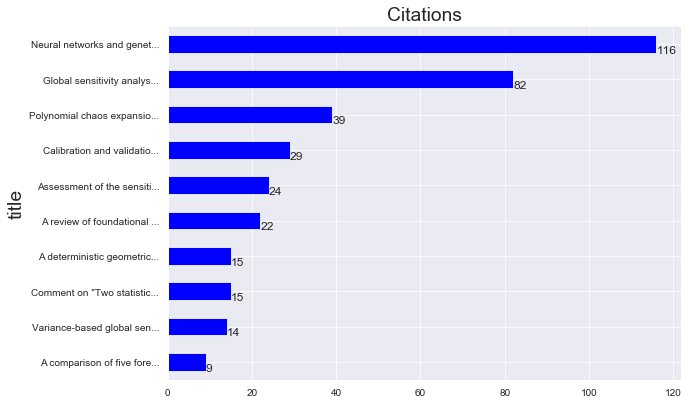

In [132]:
wos_plot.plot_citations(journal_theo)

In [133]:
journal_theo[['AU', 'year', 'DOI']][0:5]

,AU,year,DOI
title,,,
Neural networks and genet...,"Kim, Sungwon|Kim, Hung Soo",2008,10.1016/j.jhydrol.2007.12.014
Global sensitivity analys...,"Song, Xiaomeng|Zhang, Jianyun|Zhan, Chesheng|X...",2015,10.1016/j.jhydrol.2015.02.013
Polynomial chaos expansio...,"Rajabi, Mohammad Mahdi|Ataie-Ashtiani, Behzad|...",2015,10.1016/j.jhydrol.2014.11.020
Calibration and validatio...,"Kingston, GB|Maier, HR|Lambert, MF",2005,10.1016/j.jhydrol.2005.03.013
Assessment of the sensiti...,"Elsawwaf, M.|Willems, P.|Feyen, J.",2010,10.1016/j.jhydrol.2010.10.002


In [134]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal_theo, df in paper_citations_per_journal_theo.items():
    df = wosis.link_to_pub(df)
    df['journal'] = journal_theo
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    collection_theo = collection.append(df[cols_of_interest][0:10], ignore_index=True)

In [135]:
top_cited_in_top_journals_theo = collection_theo.sort_values('citations', ascending=False)

top_cited_in_top_journals_theo.head(10)

,AU,year,title,journal,citations,DOI link
0,"Kim, Sungwon|Kim, Hung Soo",2008,Neural networks and genetic algorithm approach...,JOURNAL OF HYDROLOGY,116,https://dx.doi.org/10.1016/j.jhydrol.2007.12.014
1,"Song, Xiaomeng|Zhang, Jianyun|Zhan, Chesheng|X...",2015,Global sensitivity analysis in hydrological mo...,JOURNAL OF HYDROLOGY,82,https://dx.doi.org/10.1016/j.jhydrol.2015.02.013
2,"Rajabi, Mohammad Mahdi|Ataie-Ashtiani, Behzad|...",2015,Polynomial chaos expansions for uncertainty pr...,JOURNAL OF HYDROLOGY,39,https://dx.doi.org/10.1016/j.jhydrol.2014.11.020
3,"Kingston, GB|Maier, HR|Lambert, MF",2005,Calibration and validation of neural networks ...,JOURNAL OF HYDROLOGY,29,https://dx.doi.org/10.1016/j.jhydrol.2005.03.013
4,"Elsawwaf, M.|Willems, P.|Feyen, J.",2010,Assessment of the sensitivity and prediction u...,JOURNAL OF HYDROLOGY,24,https://dx.doi.org/10.1016/j.jhydrol.2010.10.002
5,"Shin, Mun-Ju|Guillaume, Joseph H. A.|Croke, Ba...",2015,A review of foundational methods for checking ...,JOURNAL OF HYDROLOGY,22,https://dx.doi.org/10.1016/j.jhydrol.2014.11.040
6,"Obregon, N|Sivakumar, B|Puente, CE",2002,A deterministic geometric representation of te...,JOURNAL OF HYDROLOGY,15,https://dx.doi.org/10.1016/S0022-1694(02)00282-2
7,"Hill, Mary C.",2010,"Comment on ""Two statistics for evaluating para...",JOURNAL OF HYDROLOGY,15,https://dx.doi.org/10.1016/j.jhydrol.2009.10.011
8,"Dai, Heng|Ye, Ming",2015,Variance-based global sensitivity analysis for...,JOURNAL OF HYDROLOGY,14,https://dx.doi.org/10.1016/j.jhydrol.2015.06.034
9,"Linhoss, Anna C.|Siegert, Courtney M.",2016,A comparison of five forest interception model...,JOURNAL OF HYDROLOGY,9,https://dx.doi.org/10.1016/j.jhydrol.2016.04.011


In [136]:
top_cited_in_top_journals_theo.to_csv('top_cited_in_top_journals_theo.csv', index=False)

In [141]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
# co-author network
coAuths_apps = uncertainty_model__applications.networkCoAuthor()
print(mk.graphStats(coAuths_apps))

Nodes: 3512
Edges: 9236
Isolates: 47
Self loops: 0
Density: 0.00149806
Transitivity: 0.921657


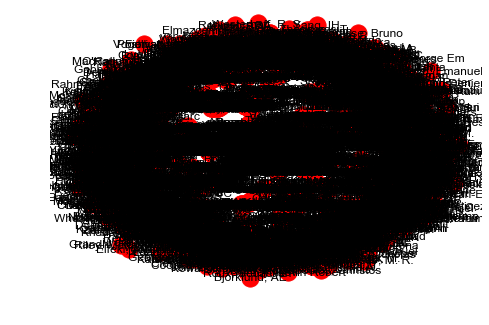

In [145]:
nx.draw_spring(coAuths_apps, with_labels=True)

In [144]:
minWeight = 3
maxWeight = 10
proccessedcoAuths_apps = coAuths_apps.copy()
mk.dropEdges(proccessedcoAuths_apps, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths_apps)

'Nodes: 3512\nEdges: 65\nIsolates: 3442\nSelf loops: 0\nDensity: 1.05428E-05\nTransitivity: 0.956044'

In [146]:
mk.dropNodesByDegree(proccessedcoAuths_apps, 1)
mk.graphStats(proccessedcoAuths_apps)

'Nodes: 70\nEdges: 65\nIsolates: 0\nSelf loops: 0\nDensity: 0.0269151\nTransitivity: 0.956044'

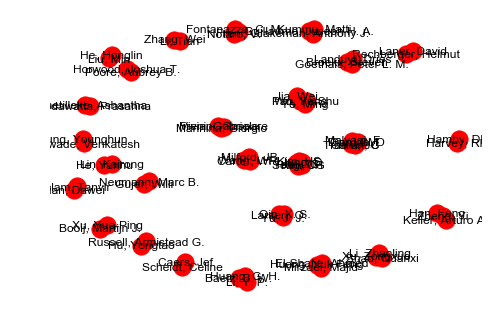

In [147]:
nx.draw_spring(proccessedcoAuths_apps, with_labels=True)

In [148]:
# co-author network
coAuths_theo = uncertainty_model__sa.networkCoAuthor()
print(mk.graphStats(coAuths_theo))

Nodes: 2146
Edges: 4796
Isolates: 45
Self loops: 2
Density: 0.00208378
Transitivity: 0.954153


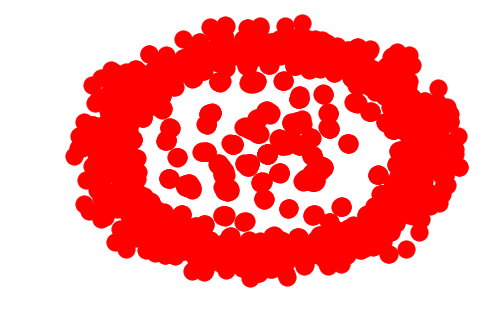

In [149]:
nx.draw_spring(coAuths_theo, with_labels=False)

In [150]:
minWeight = 3
maxWeight = 10
proccessedcoAuths_theo = coAuths_theo.copy()
mk.dropEdges(proccessedcoAuths_theo, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths_theo)

'Nodes: 2146\nEdges: 25\nIsolates: 2120\nSelf loops: 0\nDensity: 1.08621E-05\nTransitivity: 0.976744'

In [151]:
mk.dropNodesByDegree(proccessedcoAuths_theo, 1)
mk.graphStats(proccessedcoAuths_theo)

'Nodes: 26\nEdges: 25\nIsolates: 0\nSelf loops: 0\nDensity: 0.0769231\nTransitivity: 0.976744'

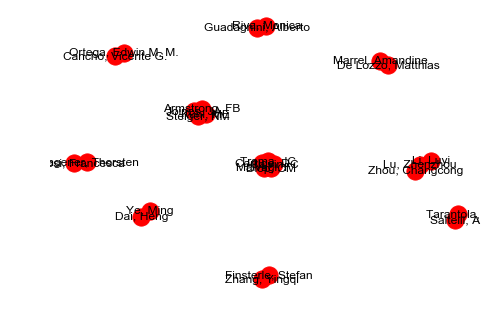

In [152]:
nx.draw_spring(proccessedcoAuths_theo, with_labels=True)

<hr>

Here the results to app_paper are sorted with reference to the packages they support.
<br> Still to complete: plot each criterion's trend

In [21]:
#keyword criteria match on app_papers
#want to see trend of keywords over time
#add languages
uncertainty_topic_df = topic_results.get_topic_by_id(4)

uncertainty_models_rc = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')
# topic_4_1_recs = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')

criteria = {
    'GLUE': set(['GLUE', 'generalized likelihood uncertainty estimation', 'distributed models', 'calibration uncertainty', 'likelihood', 'uncertainty estimation', 'epistemic error', 'rainfall-runoff models', 'equifinality', 'Plynlimon']),
    'PEST': set(['PEST', 'parameter estimation', 'model-independent parameter estimation & uncertainty analysis', 'user interfaces', 'computer systems', 'data processing', 'least squares', 'spatial systems', 'mathematical models', 'software']),
    'SALib': set(['salib', 'sensitivity analysis', 'python', 'uncertainty', 'variance-based', 'global sensitivity analysis', 'fractional factorial', 'method of morris']),
    'MADS': set(['sensitivity analysis', 'MADS', 'julia', 'julialang', 'parameter estimation', 'model inversion & calibration', 'uncertainty quantification', 'model selection', 'model averaging', 'model reduction', 'surrogate modeling', 'machine learning', 'blind source separation', 'decision analysis & support']),
    'PSUADE': set(['uncertainty quantification', 'sensitivity analysis', 'parameter estimation', 'space-filling sample', 'PSUADE', 'Problem Solving environment for Uncertainty Analysis and Design Exploration']),
    'SAFE': set(['global sensitivity analysis', 'matlab', 'octave', 'open-source software', 'safe', 'sensitivity analysis for everyone']),
    'VARS-TOOL': set(['VARS-TOOL', 'VARS', 'global sensitivity analysis', 'uncertainty analysis', 'variogram analysis of response surfaces', 'variogram', 'sobol', 'morris', 'progressive latin hypercube sampling', 'plhs', 'dynamical systems models', 'sensitivty indices', 'performance metrics']),
    'UQLab': set(['uncertainty quantification', 'uncertainty analysis', 'sensitivity analysis', 'computer systems', 'uqlab']),
    'DAKOTA': set(['dakota', 'mathematical methods', 'computing', 'computer-aided design', 'finite element method', 'nonlinear programming', 'sensitivity analysis', 'parallel processing', 'stochastic processes', 'integer processing', 'iterative methods', 'computer programs']),
    'HDMR': set(['global sensitivity analysis', 'hdmr', 'high dimensional model representation', 'matlab', 'matlab software', 'graphic user interface', 'gui']),
    'SimLab': set(['sensitivity analysis', 'uncertainty analysis', 'model development', 'global sensitivity analysis', 'simlab'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_models_rc, criteria, threshold=95.0)

KeyboardInterrupt: 

In [ ]:
criteria1_df = wosis.collate_keyword_criteria_matches(uncertainty_models_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria1_df, threshold=1)

<hr>

The following includes more analysis of the papers from topic 4 and topic 4.3. <br>
- Publication trends
- Criteria matching and trends of criteria.

In [ ]:
uncertainty_sa_df = topic_4_subtopics.get_topic_by_id(3)
uncertainty_sa_rc = wosis.extract_recs(uncertainty_sa_df.loc[:, 'id'], topic_recs, 'Topic of Interest')
# tmp_df = wosis.rc_to_df(uncertainty_sa_rc)

In [ ]:
uncertainty_sa_df.loc[:, ~topic_set.columns.isin(hide_columns)].head()

In [ ]:
#publication trend for top 10 journals
wos_plot.plot_journal_pub_trend(uncertainty_sa_rc)

In [ ]:
#Top 10 jorunals by number of publications
wos_plot.plot_pubs_per_journal(uncertainty_sa_rc, top_n=10, annotate=True, show_stats=True)

In [ ]:
#top papers by cited papers within the corpora
wosis.analysis.pub_citations(uncertainty_sa_rc)[0:5]

#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

In [ ]:
# first 10 papers in chosen topic (unordered)
uncertainty_sa_doi = wosis.link_to_pub(uncertainty_sa_rc)  # Creates a new column called 'DOI link'
uncertainty_sa_doi.loc[:, ~uncertainty_sa_doi.columns.isin(hide_columns)].head(10)

In [ ]:
uncertainty_sa_doi.to_csv('topic_4_3.csv')

In [ ]:
# want to see trend of global SA over years
# also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_sa_rc, criteria, threshold=95.0)

In [ ]:
criteria_df = wosis.collate_keyword_criteria_matches(uncertainty_sa_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [ ]:
# want to view the papers in the above plot
# crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
# crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

criteria_df.loc[criteria_df['num_criteria_match'] >= 2].sort_values('year').head()

In [ ]:
lsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['local sensitivity', 'LSA', 'local sensitivity analysis'], threshold=95.0)

In [ ]:
gsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['global sensitivity', 'GSA', 'global sensitivity analysis'], threshold=95.0)

In [ ]:
oat_matches = wosis.keyword_matches(uncertainty_sa_rc, ['one-at-a-time', 'OAT'], threshold=95.0)

In [ ]:
lsa_matches

In [ ]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches], 
                          topic_4_recs)

<hr>

Network analysis, cocite and coauthor networks
<br> Further formatting/data extraction required, see networkx documentation

In [ ]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# co-author network
coAuths = topic_recs.networkCoAuthor()
print(mk.graphStats(coAuths))

In [ ]:
nx.draw_spring(coAuths, with_labels=False)

In [ ]:
# highly cited co-atuhor network, how do I limit nodes? Needs to use topic 1 only, not full data base
minWeight = 3
maxWeight = 10
proccessedcoAuths = coAuths.copy()
mk.dropEdges(proccessedcoAuths, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths)

In [ ]:
mk.dropNodesByDegree(proccessedcoAuths, 1)
mk.graphStats(proccessedcoAuths)

In [ ]:
nx.draw_spring(proccessedcoAuths, with_labels=True)

In [ ]:
minWeight = 30
maxWeight = 35
coCites = uncertainty_sa_rc.networkCoCitation()
mk.dropEdges(coCites, minWeight, maxWeight, dropSelfLoops=True)
mk.dropNodesByDegree(coCites, 5)
print(mk.graphStats(coCites))

In [ ]:
nx.draw_spring(coCites, with_labels=True)